In [1]:
# Criar sessão Spark

import os
import sys
from pyspark.sql import SparkSession

# Caminho da pasta de saída
output_folder = "../Scripts/output"

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder \
    .appName("Análise de Transações Ethereum") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

In [2]:
# Criar um DataFrame vazio para armazenar os dados dos blocos
combined_block_df = None

file_path = "../Scripts/output/block/block.csv"

# Ler o arquivo CSV
combined_block_df = spark.read.csv(file_path, header=True, inferSchema=True)

In [3]:
combined_block_df = combined_block_df.drop("Gas_Limit")
combined_block_df = combined_block_df.drop("Gas_Used")
combined_block_df = combined_block_df.drop("Timestamp_Block")

In [4]:
# Criar um DataFrame vazio para armazenar os dados dos blocos
combined_swap_df = None

file_path = "../Scripts/output/swap/swap_transactions.csv"

# Ler o arquivo CSV
combined_swap_df = spark.read.csv(file_path, header=True, inferSchema=True)

In [5]:
combined_swap_df = combined_swap_df.drop("Block_ID")

In [6]:
combined_transaction_df = None

file_path = "../Scripts/output/transaction/transactions.csv"

# Ler o arquivo CSV
combined_transaction_df = spark.read.csv(file_path, header=True, inferSchema=True)

In [7]:
from pyspark.sql.functions import col, isnan, when, trim

def to_null(c):
    return when(~(col(c).isNull() | isnan(col(c)) | (trim(col(c)) == "")), col(c))

combined_swap_df_cleaned = combined_swap_df.select([to_null(c).alias(c) for c in combined_swap_df.columns]).na.drop()

combined_swap_df_cleaned = combined_swap_df_cleaned.withColumn("From_Token_Price", when(col("From_Token_Price") == 0, float('nan')).otherwise(col("From_Token_Price")))
combined_swap_df_cleaned = combined_swap_df_cleaned.withColumn("To_Token_Price", when(col("To_Token_Price") == 0, float('nan')).otherwise(col("To_Token_Price")))

In [8]:
df_combined = combined_block_df.join(combined_transaction_df, "Block_ID").join(combined_swap_df_cleaned, "Hash_Transaction")

In [9]:
df_combined_pandas = df_combined.toPandas()
df_combined_pandas.to_csv('combined_df.csv', index=False)

In [10]:
from pyspark.sql import functions as F

# Filtrar as transações de compra
compras_df = df_combined.filter(df_combined.To_Token_Symbol.isNotNull()) \
               .groupBy("To_Token_Symbol") \
               .agg(F.count("*").alias("Num_Compras")) \
               .orderBy(F.desc("Num_Compras")) \
               .limit(10)

# Filtrar as transações de venda
vendas_df = df_combined.filter(df_combined.From_Token_Symbol.isNotNull()) \
              .groupBy("From_Token_Symbol") \
              .agg(F.count("*").alias("Num_Vendas")) \
              .orderBy(F.desc("Num_Vendas")) \
              .limit(10)

# Exibir as 10 moedas mais compradas
print("As 10 moedas mais compradas:")
compras_df.show()

# Exibir as 10 moedas mais vendidas
print("As 10 moedas mais vendidas:")
vendas_df.show()

As 10 moedas mais compradas:
+---------------+-----------+
|To_Token_Symbol|Num_Compras|
+---------------+-----------+
|           WETH|       3565|
|         PEPINU|        248|
|              X|        230|
|         sFLOKI|        229|
|          sPEPE|        166|
|           ZUCC|        165|
|      TURBO_INU|        142|
|         WOJINU|        131|
|           LIZA|        120|
|        PEPNEKO|        114|
+---------------+-----------+

As 10 moedas mais vendidas:
+-----------------+----------+
|From_Token_Symbol|Num_Vendas|
+-----------------+----------+
|             WETH|      3731|
|           PEPINU|       231|
|           sFLOKI|       179|
|                X|       165|
|           WOJINU|       150|
|             ZUCC|       131|
|           BOBINU|       125|
|        TURBO_INU|       115|
|            sPEPE|       110|
|            PEPIG|       101|
+-----------------+----------+



In [16]:
from pyspark.sql import functions as F

# Filtrar as transações de compra
compras_df = df_combined.filter(df_combined.To_Token_Symbol.isNotNull()) \
                       .groupBy("To_Token_Symbol", "Timestamp_Transaction") \
                       .agg(F.count("*").alias("qtd"), F.sum("To_Token_Holders_Count").alias("Total_Holders")) \
                       .withColumnRenamed("To_Token_Symbol", "Token_Symbol")

# Filtrar as transações de venda
vendas_df = df_combined.filter(df_combined.From_Token_Symbol.isNotNull()) \
                      .groupBy("From_Token_Symbol", "Timestamp_Transaction") \
                      .agg(F.count("*").alias("qtd"), F.sum("From_Token_Holders_Count").alias("Total_Holders")) \
                      .withColumnRenamed("From_Token_Symbol", "Token_Symbol")

# Unir os resultados das transações de compra e venda
result_df = compras_df.unionAll(vendas_df)

# Calcular a média de holders por Token_Symbol
media_df = result_df.groupBy("Token_Symbol") \
                    .agg((F.sum("Total_Holders") / F.sum("qtd")).alias("Media_Holders")) \
                    .orderBy(F.desc("Media_Holders")) \
                    .limit(10)

# Exibir o resultado
print("As 10 moedas negociadas com maiores números médio de holders:")
media_df.show()

As 10 moedas negociadas com maiores números médio de holders:
+------------+------------------+
|Token_Symbol|     Media_Holders|
+------------+------------------+
|        USDT| 4411739.945945946|
|        USDC|         1700028.5|
|        WETH| 811072.9705317982|
|         BAT|          459338.0|
|         CRO|          298625.0|
|       KISHU|          260896.0|
|        AGIX|           63671.0|
|     PEPE2.0|           13619.3|
|        SDAO|           12977.0|
|         VOW|12902.085714285715|
+------------+------------------+



In [12]:
from pyspark.sql.functions import col

# Obtenha as 10 moedas mais compradas
top_10_compradas = df_combined.filter(df_combined.To_Token_Symbol.isNotNull()) \
                             .groupBy("To_Token_Symbol") \
                             .count() \
                             .orderBy(F.desc("count")) \
                             .limit(10) \
                             .select(col("To_Token_Symbol").alias("Token_Symbol"))

# Obtenha as transações de compra de determinada moeda e o número de holders
compras_df = df_combined.alias("compras") \
                       .join(top_10_compradas, top_10_compradas.Token_Symbol == col("compras.To_Token_Symbol"), "inner") \
                       .select("compras.Timestamp_Transaction", "compras.To_Token_Symbol", "compras.To_Token_Holders_Count") \
                       .withColumnRenamed("To_Token_Symbol", "Token_Symbol") \
                       .withColumnRenamed("To_Token_Holders_Count", "Token_Holders_Count")

# Obtenha as transações de venda de determinada moeda e o número de holders
vendas_df = df_combined.alias("vendas") \
                      .join(top_10_compradas, top_10_compradas.Token_Symbol == col("vendas.From_Token_Symbol"), "inner") \
                      .select("vendas.Timestamp_Transaction", "vendas.From_Token_Symbol", "vendas.From_Token_Holders_Count") \
                      .withColumnRenamed("From_Token_Symbol", "Token_Symbol") \
                      .withColumnRenamed("From_Token_Holders_Count", "Token_Holders_Count")

result_df = compras_df.unionAll(vendas_df)

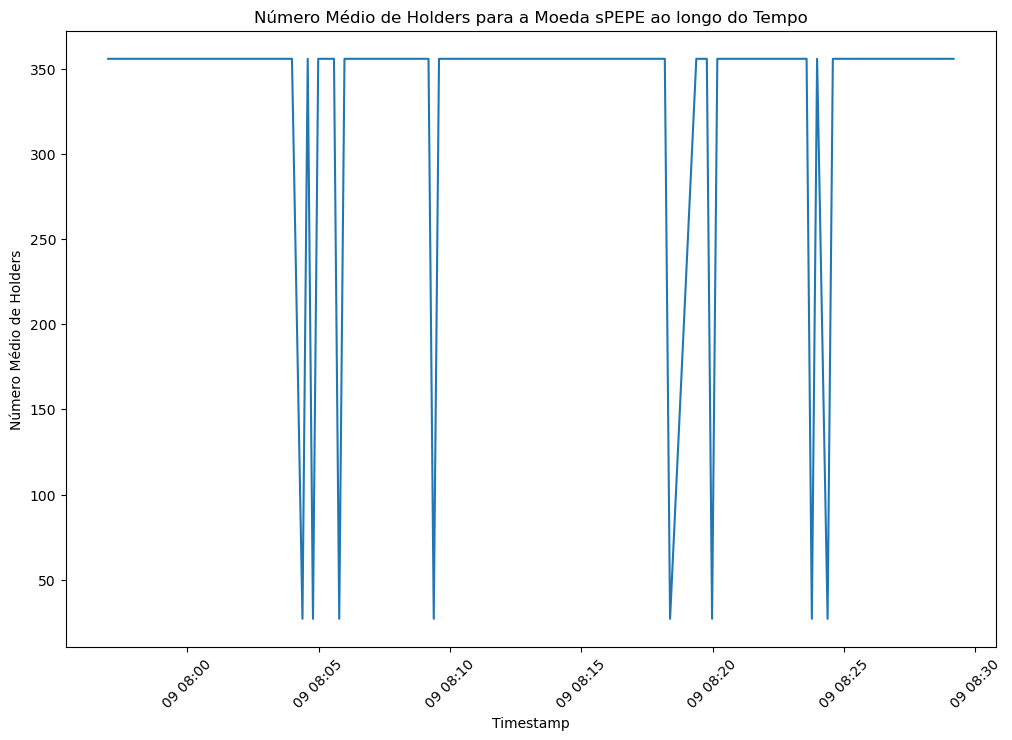

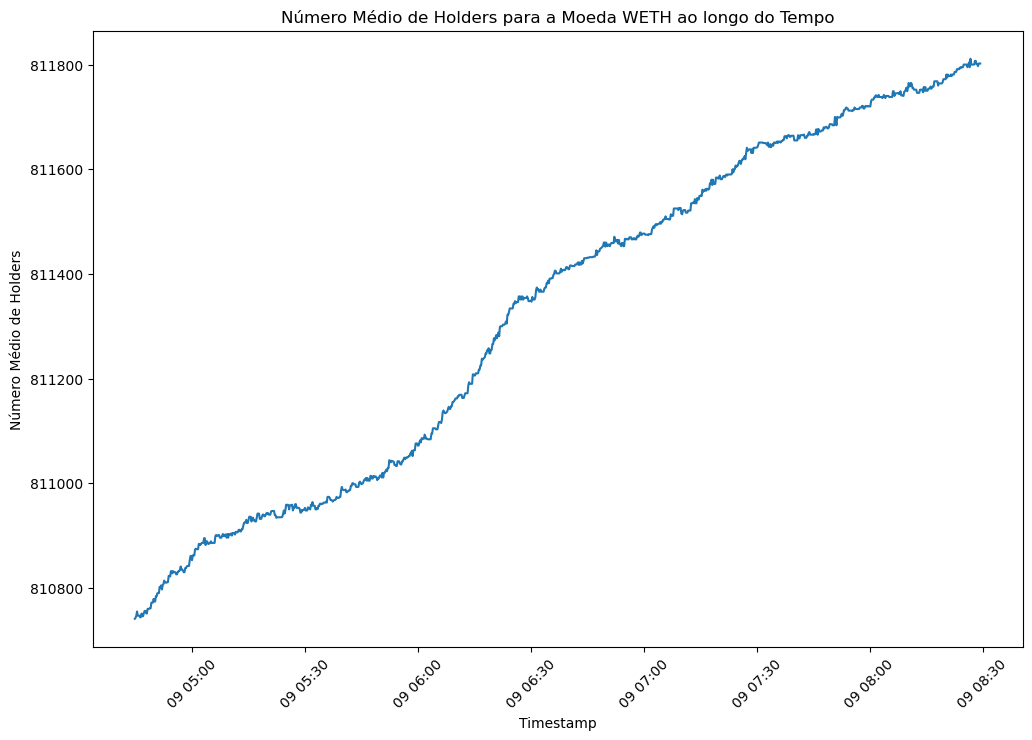

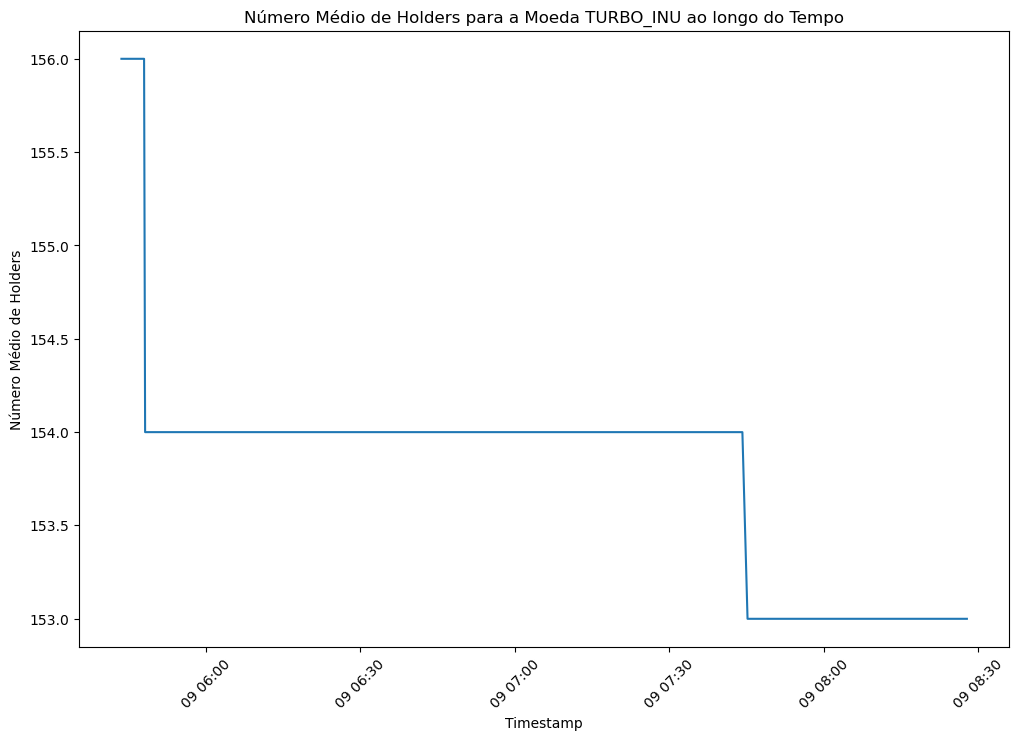

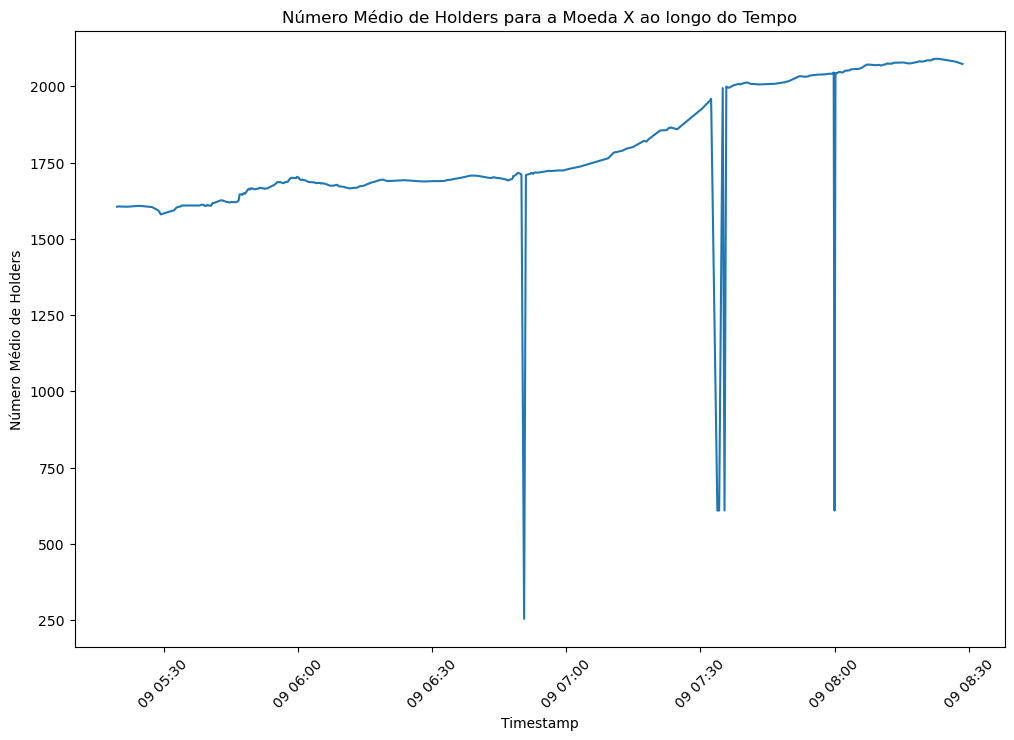

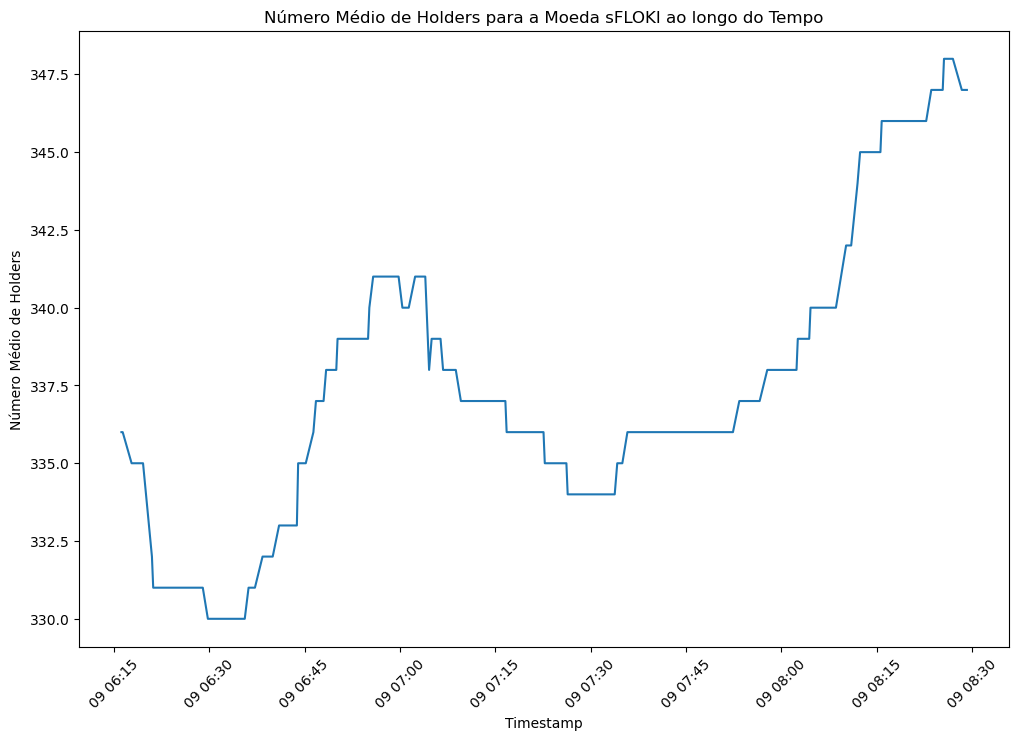

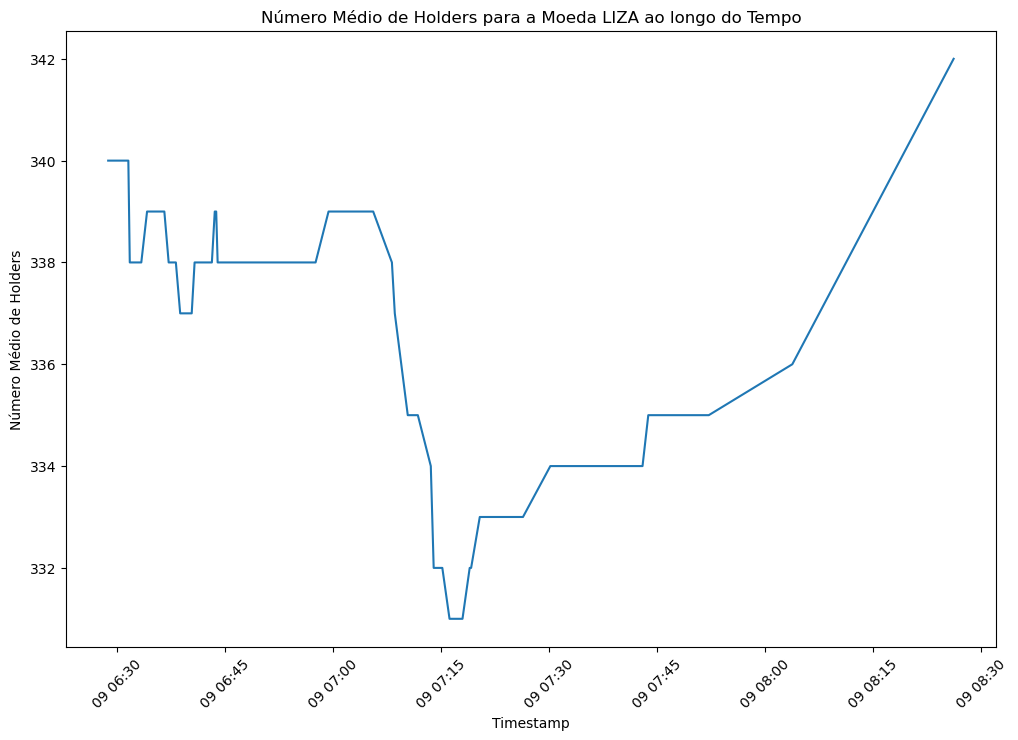

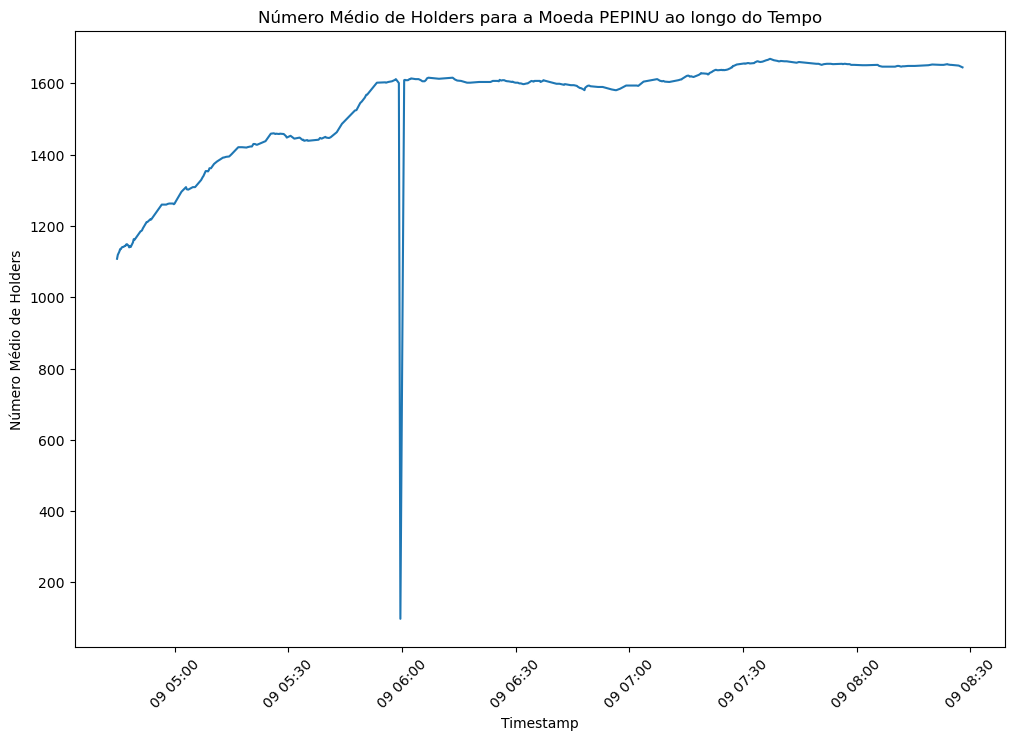

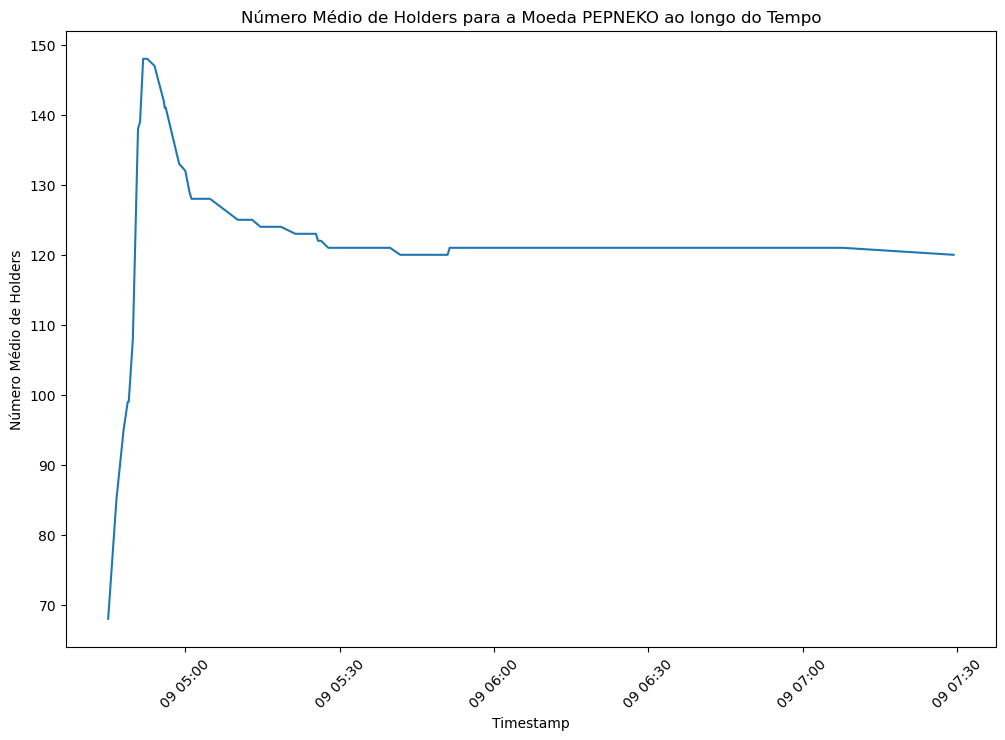

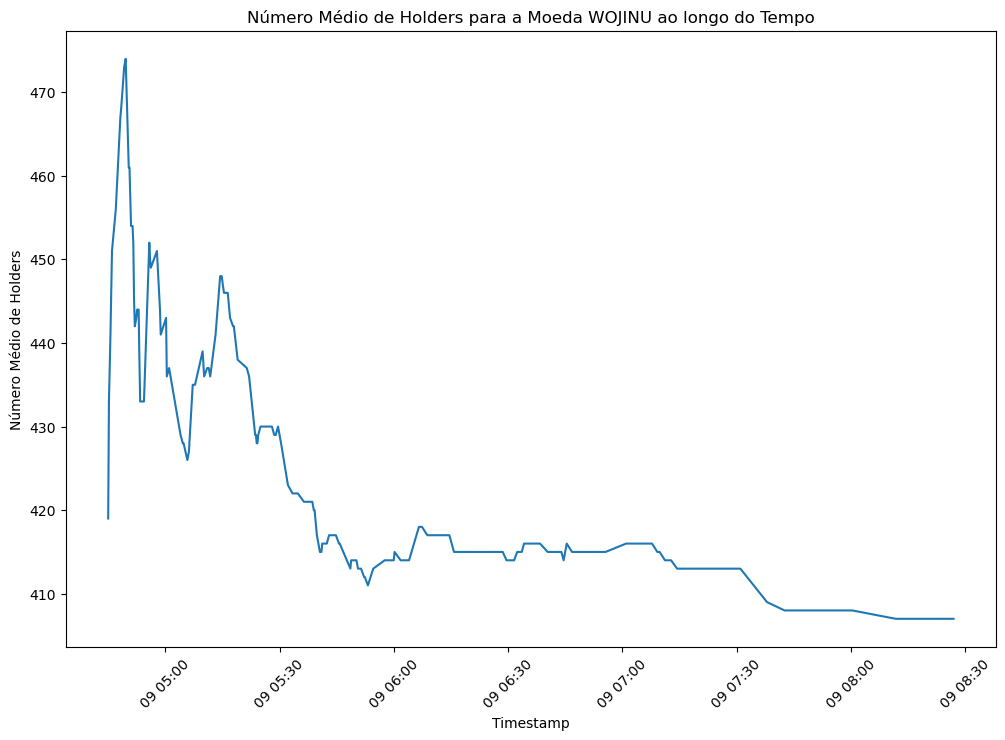

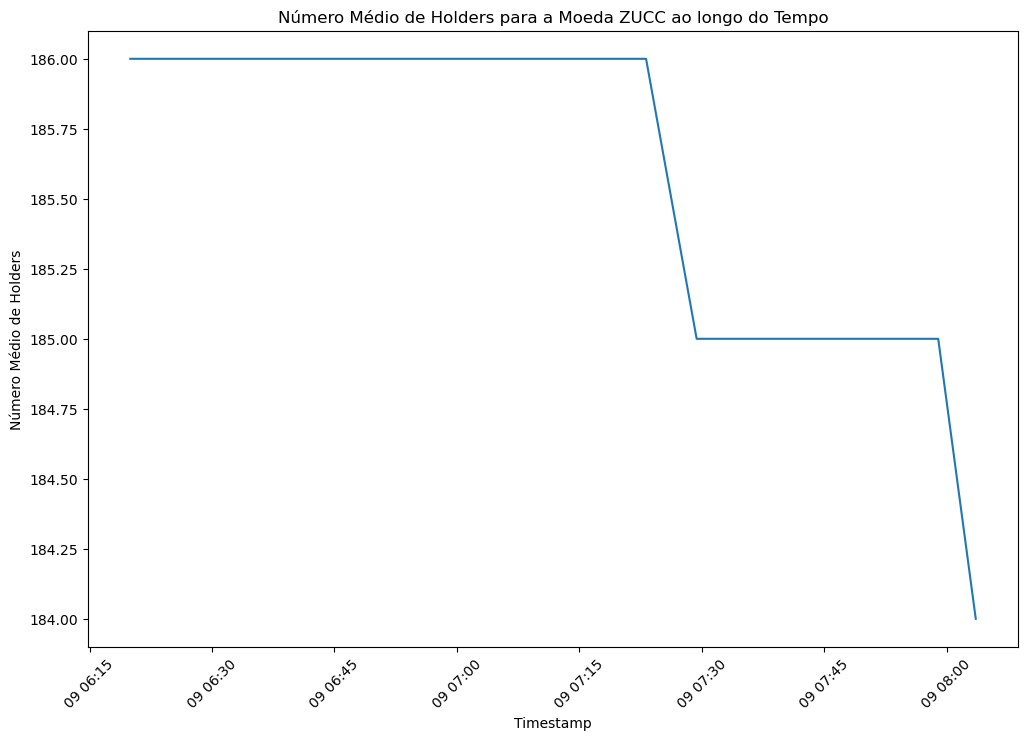

In [13]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import expr, collect_list, struct
import datetime

# Agrupe o dataframe e calcule a mediana do número de holders para cada moeda em cada timestamp
grouped_df = result_df.groupBy("Timestamp_Transaction", "Token_Symbol").agg(expr("percentile_approx(Token_Holders_Count, 0.5)").alias("median"))

# Ordene o dataframe pelo campo "Timestamp_Transaction"
sorted_df = grouped_df.orderBy("Timestamp_Transaction")

# Coleta os dados do dataframe para uso no matplotlib
data_dict = {}

# Agrupe o dataframe e calcule a mediana do número de holders para cada moeda em cada timestamp
grouped_df = sorted_df.groupBy("Token_Symbol").agg(collect_list(struct("Timestamp_Transaction", "median")).alias("data_list"))

# Converta o resultado em um dicionário
data_dict = {row["Token_Symbol"]: {"timestamps": [r["Timestamp_Transaction"] for r in row["data_list"]],
                                    "holders_counts": [r["median"] for r in row["data_list"]]}
             for row in grouped_df.collect()}

# Itera sobre os dados do dicionário
for symbol, data in data_dict.items():
    timestamps = data["timestamps"]
    holders_counts = data["holders_counts"]

    # Converte os timestamps em formato Unix para formato de data e hora
    dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]

    # Plota o gráfico
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(dates, holders_counts, label=symbol)
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Número Médio de Holders")
    ax.set_title(f"Número Médio de Holders para a Moeda {symbol} ao longo do Tempo")

    # Rotaciona os rótulos do eixo x
    plt.xticks(rotation=45)

    plt.show()

In [14]:
import matplotlib.pyplot as plt

# Obtenha as 10 moedas mais vendidas
top_10_vendidas = df_combined.filter(df_combined.From_Token_Symbol.isNotNull()) \
                             .groupBy("From_Token_Symbol") \
                             .count() \
                             .orderBy(F.desc("count")) \
                             .limit(10) \
                             .select(col("From_Token_Symbol").alias("Token_Symbol"))

# Obtenha as transações de compra de determinada moeda e o número de holders
compras_df = df_combined.alias("compras") \
                       .join(top_10_vendidas, top_10_vendidas.Token_Symbol == col("compras.To_Token_Symbol"), "inner") \
                       .select("compras.Timestamp_Transaction", "compras.To_Token_Symbol", "compras.To_Token_Holders_Count") \
                       .withColumnRenamed("To_Token_Symbol", "Token_Symbol") \
                       .withColumnRenamed("To_Token_Holders_Count", "Token_Holders_Count")

# Obtenha as transações de venda de determinada moeda e o número de holders
vendas_df = df_combined.alias("vendas") \
                      .join(top_10_vendidas, top_10_vendidas.Token_Symbol == col("vendas.From_Token_Symbol"), "inner") \
                      .select("vendas.Timestamp_Transaction", "vendas.From_Token_Symbol", "vendas.From_Token_Holders_Count") \
                      .withColumnRenamed("From_Token_Symbol", "Token_Symbol") \
                      .withColumnRenamed("From_Token_Holders_Count", "Token_Holders_Count")

result_df = compras_df.unionAll(vendas_df)

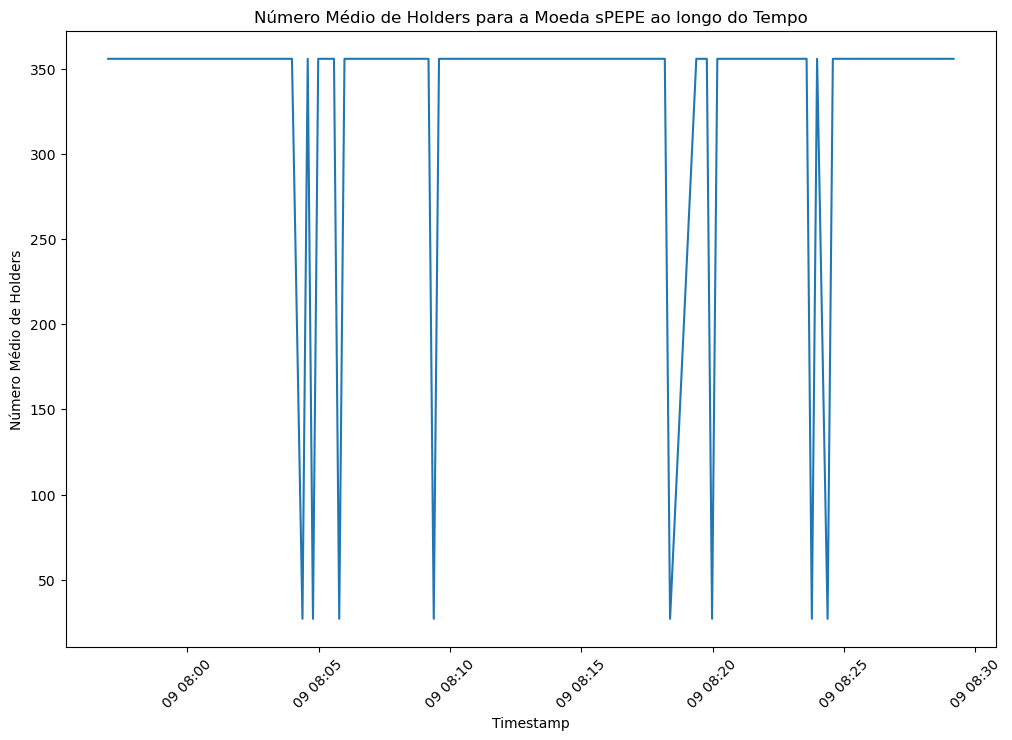

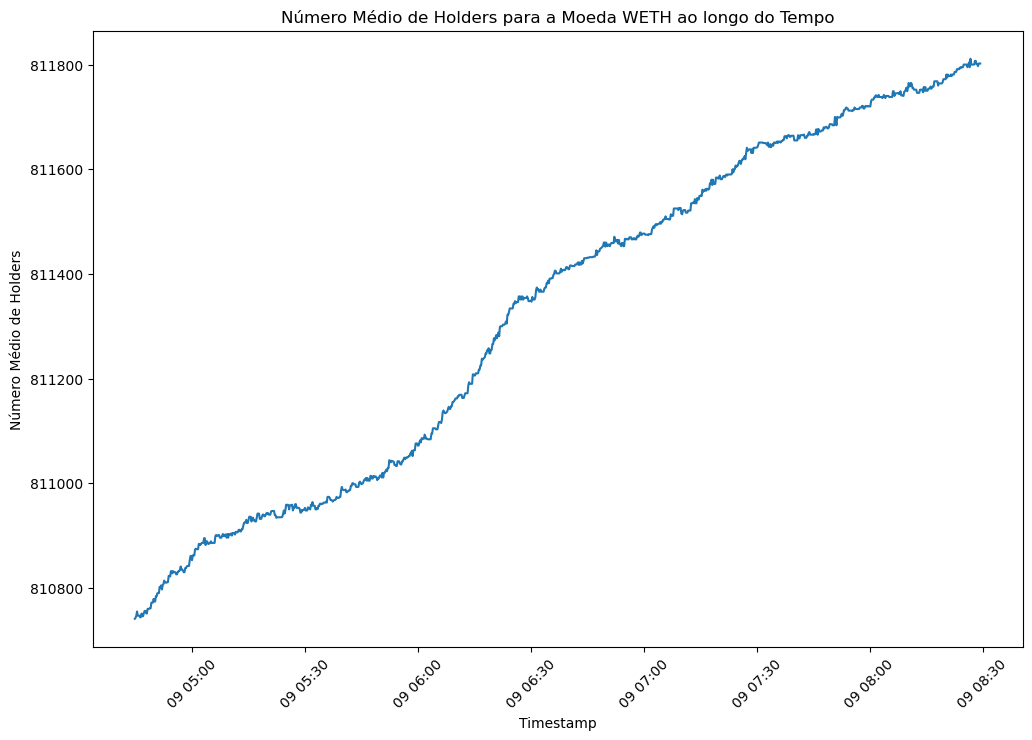

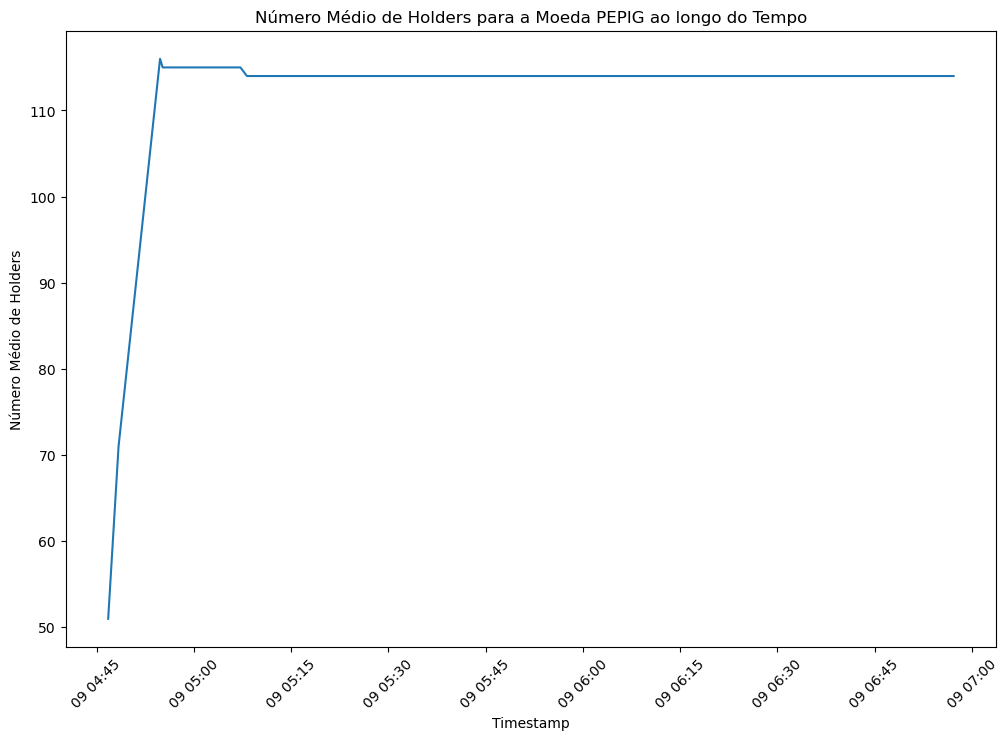

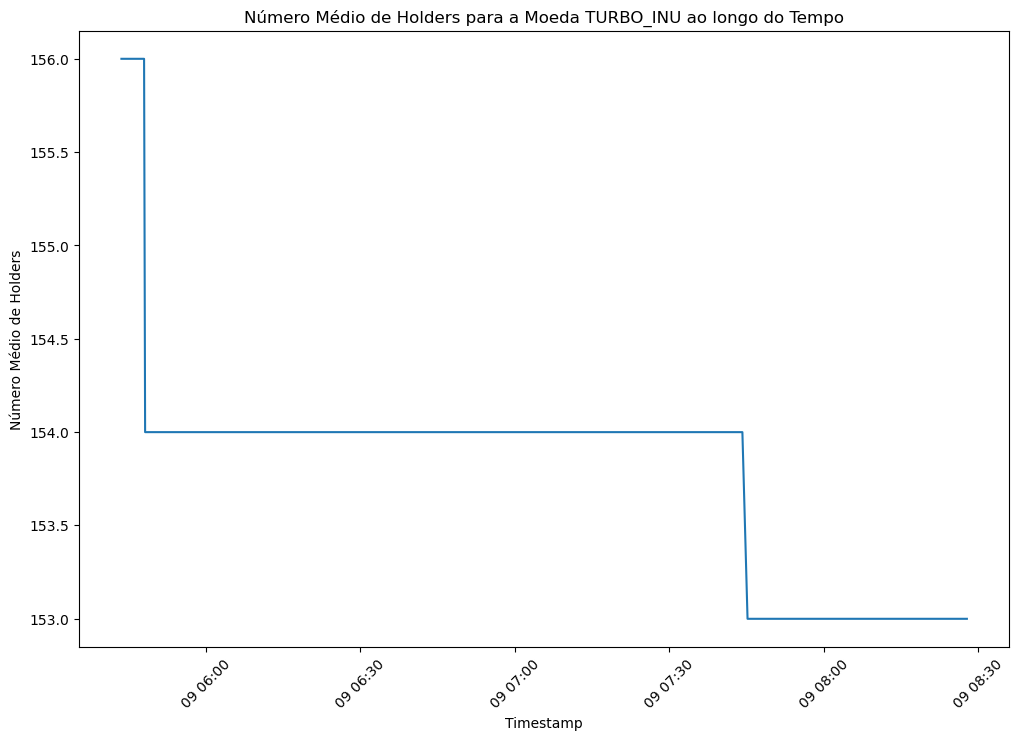

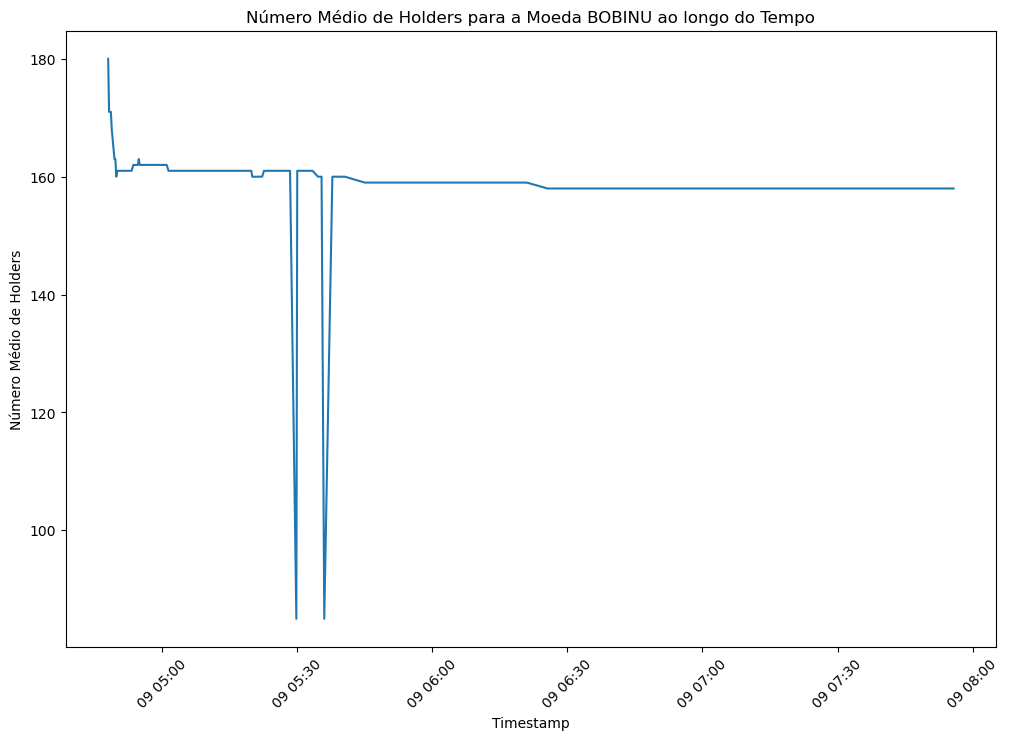

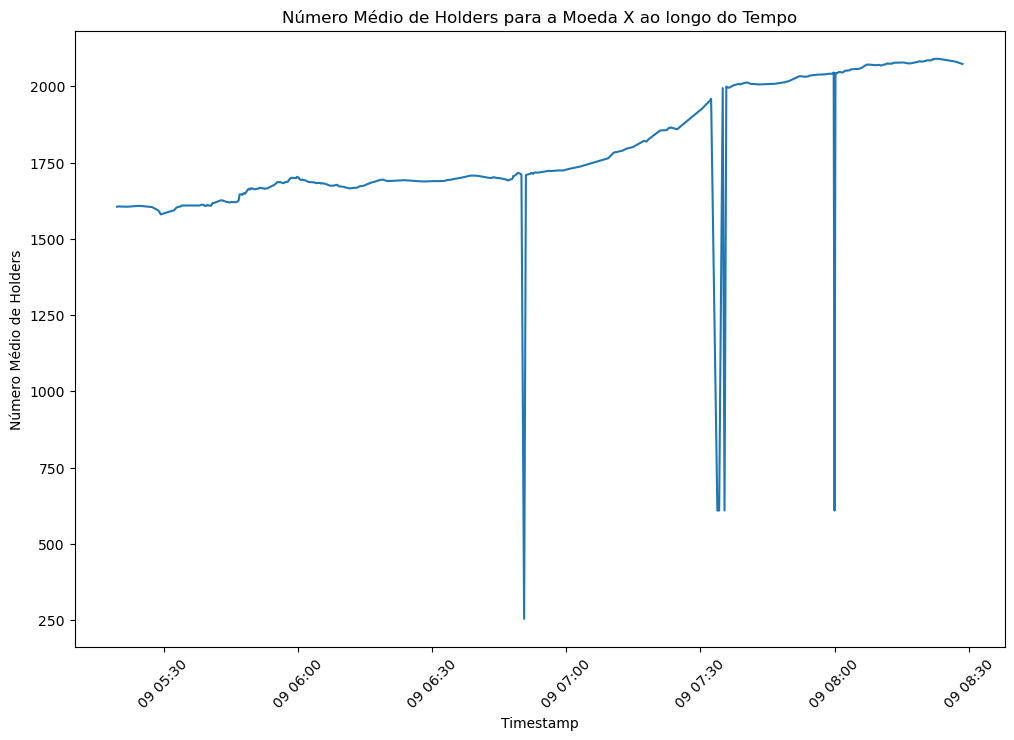

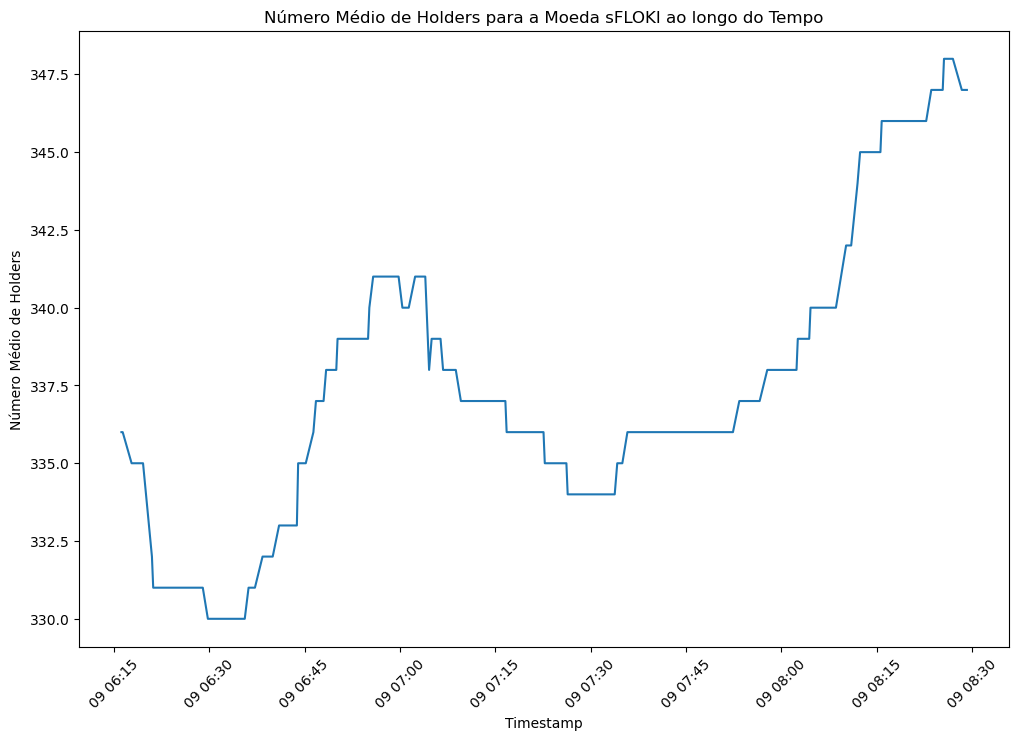

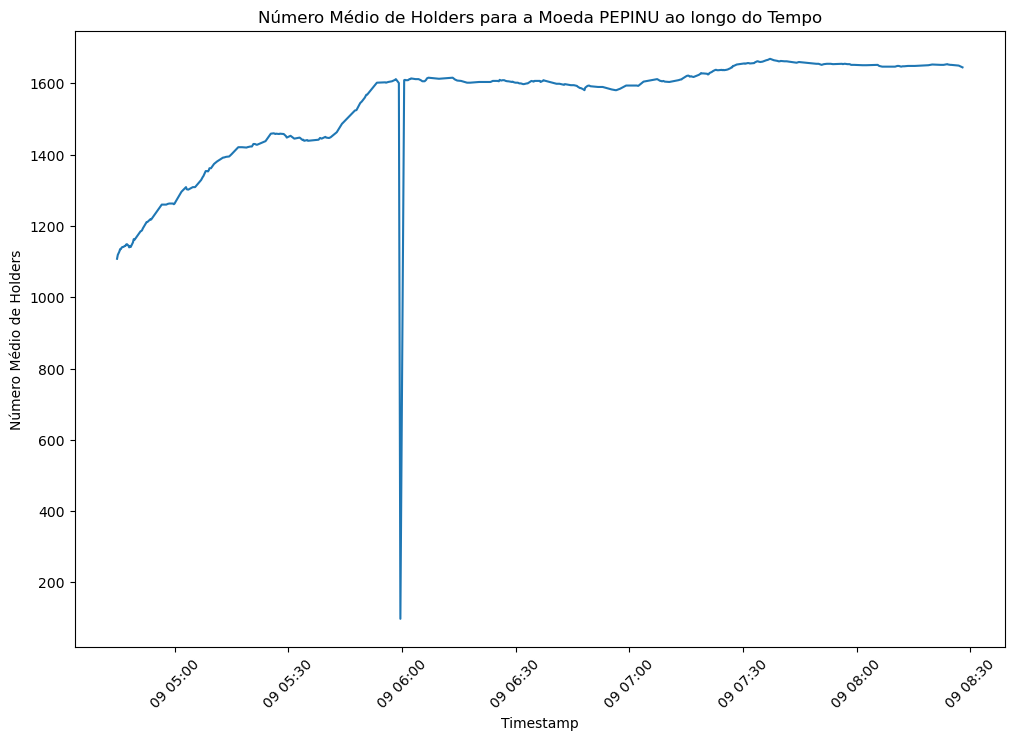

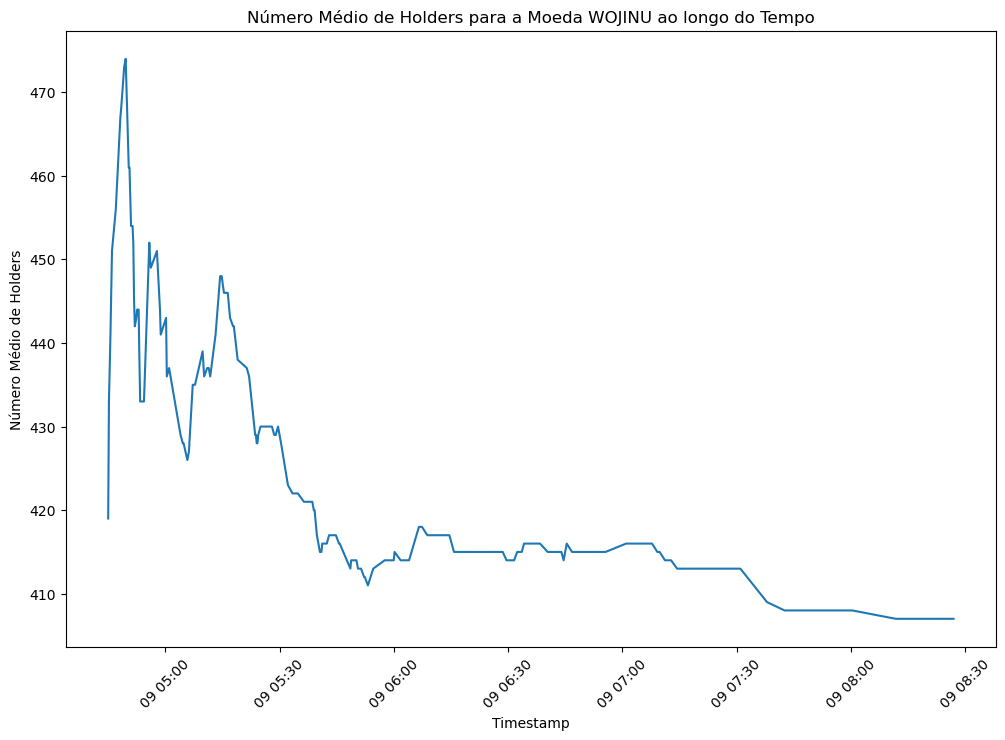

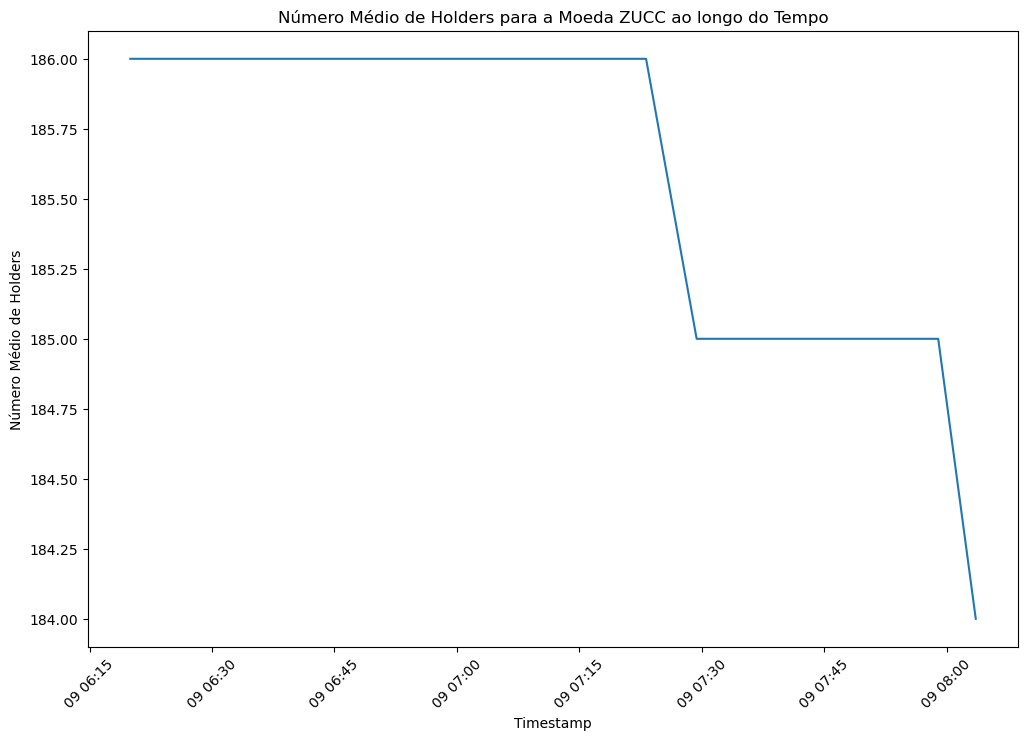

In [15]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import expr, collect_list, struct
import datetime

# Agrupe o dataframe e calcule a mediana do número de holders para cada moeda em cada timestamp
grouped_df = result_df.groupBy("Timestamp_Transaction", "Token_Symbol").agg(expr("percentile_approx(Token_Holders_Count, 0.5)").alias("median"))

# Ordene o dataframe pelo campo "Timestamp_Transaction"
sorted_df = grouped_df.orderBy("Timestamp_Transaction")

# Coleta os dados do dataframe para uso no matplotlib
data_dict = {}

# Agrupe o dataframe e calcule a mediana do número de holders para cada moeda em cada timestamp
grouped_df = sorted_df.groupBy("Token_Symbol").agg(collect_list(struct("Timestamp_Transaction", "median")).alias("data_list"))

# Converta o resultado em um dicionário
data_dict = {row["Token_Symbol"]: {"timestamps": [r["Timestamp_Transaction"] for r in row["data_list"]],
                                    "holders_counts": [r["median"] for r in row["data_list"]]}
             for row in grouped_df.collect()}

# Itera sobre os dados do dicionário
for symbol, data in data_dict.items():
    timestamps = data["timestamps"]
    holders_counts = data["holders_counts"]

    # Converte os timestamps em formato Unix para formato de data e hora
    dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]

    # Plota o gráfico
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(dates, holders_counts, label=symbol)
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Número Médio de Holders")
    ax.set_title(f"Número Médio de Holders para a Moeda {symbol} ao longo do Tempo")

    # Rotaciona os rótulos do eixo x
    plt.xticks(rotation=45)

    plt.show()